# Control Variates Applied to Binomial Tree Pricing of American Put Options

This project provide a practical Python implementation of the CV enhanced CRR binomial tree pricing algorithm proposed on the publication C Chiu, T Dai, Y Lyuu, L Liu, Y Chen, *Option pricing with the control variate technique beyond Monte Carlo simulation*, The North American Journal of Economics and Finance, Volume 62, 2022, Article 101772, DOI: 10.1016/j.najef.2022.101772


**Why is it be useful?**

Modern financial markets are characterized by their rapid reactions to news and market movements. When pricing financial derivatives in more realistic settings, it is not always possible to get closed-form formulas for their prices. In these cases, approximate closed-form formulas and numerical algorithms are valuable alternatives, but:

- the former can be efficient but inaccurate;
- the latter can be time-consuming, although their accuracy improves with increasing computational resources.

Therefore, when accuracy is particularly important, having an efficient algorithm for option pricing can make a significant difference. Traders, for example, can update prices, hedge positions, and manage risk in real time in the fastest way. If the algorithm is slow, financial operators may quote outdated prices, mismanage risk, or miss trading opportunities. Efficient pricing thus enables faster decision-making, more accurate risk control, lower operational expenses, and a stronger competitive position in modern electronic markets.

## Control variates (CV) technique in short

It is a *variance-reduction technique* for the Monte Carlo (MC) method (i.e., a method used in Monte Carlo simulations to improve the precision of an estimate without increasing the number of simulations) which the reference paper show that can be extended to other numerical pricing methods.

### General use in Monte Carlo method

- Let $Y$ be a random variable;
- denote by $E[Y]$ the expected value of $Y$;
- denote by $\mathbb{E}[Y]$ the MC estimator $\sum_{i=1}^n Y(\omega_i)/n$ where $\omega_i$ are random samples.

Consider the decomposition $Y = (Y-C) + C$ where $C$, called the CV, is a random variable. If $C$ is s.t. $E[C]$ is known in closed form and $\mathbb{E}[Y-C]$ has a smaller variance than $\mathbb{E}[Y]$, then one should estimate $E[Y]$ with
$$
\mathbb{E}[Y-C] + E[C] = \left( \frac{1}{n} \sum_{i=1}^n (Y(\omega_i)- C(\omega_i)) \right) + E[C] 
$$
whenever the trade off between the improved accuracy made possible by the CVs and the extra computational cost tha it cause is advantageous.

### Extention to other numerical methods

Suppose we want to evaluate $𝖳(f)$, the linear operator $𝖳$ acting on a function $f$, and we have access to its numerical approximation $\mathbb{T}(f)$. For example, $𝖳$ may be the integral operator  

$$𝖳(f) = \int_a^b f(x) \, dx$$


while $\mathbb{T}$ is its approximation using the trapezoidal rule. The linearity of $𝖳$ is key for the CV technique, because it guarantees  

$$𝖳(f) = 𝖳(f - g) + 𝖳(g)$$

for any control function $g$. The goal is to choose a $g$ for which $𝖳(g)$ is known in closed form and for which the error or variance of $\mathbb{T}(f − g)$ is smaller than that of $\mathbb{T}(f)$.

If such a $g$ is available then, it can be used as CV and $\mathbb{T}(f-g) + 𝖳(g)$ is a more accurate approximation than $\mathbb{f}$.

This paper enumerates three different categories of option pricing methods: the Fourier transform method, the convolution method, and the tree method. I will focus on the implementation of the latter only.

## CV Binomial tree algorithm

This section enhances the CRR (Cox-Ross-Rubinstein) binomial tree for pricing American puts with a CV.



CRR tree discretize the Black-Scholes model in both time and space. 

Consider a vanilla European put option with strike $K$ and maturity $T$. Considering $n$ time steps, $S_t$ is obeserved at time $t_i = i*dt$, where $dt = T/n$.

At any time $S_t$ either increase by a factor of $u = e^{\sigma\sqrt{dt}} > 1$, with probability $p$ or decrease by a factor of $d = 1/u$ with probability $q = 1-p$ under the risk-neutral measure.

The pricing of the oprion proceed backward in time:
$$
put(t_i, S_{t_i}) = e^{-rdt}(p * put(t_i, S_{t_{i}}, u) + q * put(t_i, S_{t_i}, d))
$$
for $i = n-1, n-2, ..., 0.$. The desired price is $put(0, S_0)$. It is well-known that the put price converges to the Black–Scholes formula as $n \to \infty$.

American options are options that can be exercised any time before maturity and their fair price of an American put option, under the risk-neutral probability, is given by $$ \sup_{\tau \in \mathcal{T}_{[0,T]}} E\left[e^{-r \tau}(K - S_\tau)^+\right] $$

where $\mathcal{T}_{[0,T]}$ is the set of all stopping times in $[0,T]$.

In a binomial tree setting, at each instant of time, their price will be given by:
$$
\max(put(t_i, S_{t_i}), (K-S_{t_i})^+)
$$
where $put(t_i, S_{t_i})$ is calculated as shown before by backward induction. This backward induction though is a linear operator; hence a CV can be added to it and can play the role of $\mathbb{T}$. The role of $T$ instead can be played by the operator that takes the exact option prices at time $t_{i+1}$ to generate price at time $t_i$.

Now, we need to pick a CV that is close to the American put price under the Black–Scholes model and has a closed-form formula when $T$ is applied. A clear choice is the Black-Scholes formula for European put.

Then, the backward induction step is replaced by the following:
- Take the put vector and subtract the vector of EU BS put prices at time $t_{i+1}$ to yield the difference vector $put_{diff}$ (i.e., the premium for the right of early excercise);
- Apply backward induction on $put_{diff}$;
- Add the EU BS put prices at time $t_i$ to $put_{diff}$.

## CV Enhanced

The CV version is less efficient than the CRR tree algorithm because the expensive Black–Scholes formula is evaluated at every node of the tree while CRR tree involves only simple arithmetic operations at each node.
We next proceed to speed up the CV version without affecting the final price.



The BS formula is evaluated $i + 1$ times to recover the put prices from $put_{diff}$.

By focusing mainly on the $put_{diff}$ vector and only considering put prices close to the early exercise boundary, it becomes possible to compute the Black-Scholes formula just a few times per iteration, rather than $i + 1$ times. Therefore, we will update the values of $put_{diff}$ in the following way:

$$
put_{diff} \leftarrow \max(put_{diff}, \, payoff - CV^i)
$$

We call $j^*_i$ the index corresponding to the asset price $ S_0u^{i-2j^*_i} $ which represents the early exercise boundary for the binomial tree model. Hence, we have:

$$
putt_{diff} \leftarrow
\begin{cases}
    put_{diff}[j] \hspace{2cm} \text{if} \,\,\, j < j^*_i\\
    payoff[j] - CV^i[j] \hspace{0.5cm} \text{if} \,\,\, j \geq j^*_i
\end{cases}
$$
for $j = 0, 1, 2, ..., i$.

Thanks to that, we can avoid using the BS formula for nodes $j < j^*_i$. Moreover, we can do better and we can still avoid some computations for most of the $ j \geq j^*_i $.

First of all, the evaluation of $put_{diff}$ at the early exercise nodes is unnecessary, so the first $j^*_i - 1$ elements of the $put_{diff}$ vector are computed if $j^*_i \geq 1$. If $j^*_i = 0$, then the early exercise applies to all nodes for time $t<t_i$ and the put price is simply given by $K-S_0$.

Then, we modify the way in which we update the $put_{diff}$ vector, by replacing the bound for $j$ with $j^*_{i-1}$ so that the BS formula is needed only for $ j^*_i \geq j \geq j^*_{i-1}$ instead of the much wider $j^*_{i} \leq j$.

The problem is now to find $j^*_i$. Before the for loop, we define $j^*_n$ as the smallest $j$ such that $S_0 u^{i-2j}<K$. Then we start searching for $j^*_i$ at each iteration and we check if:
$$ e^{-r \Delta t}(p*put_{diff}[j] + q*put_{diff}[j+1]) < payoff[j] - CV[j] $$

Then, we find again the smallest $j$ such that this inequality holds starting with $j = j^*_{i+1}$, as $j^*_{i}$ is usually near $j^*_{i+1}$, and we proceed like that:
- if the inequality above is satisfied we try with $j^*_{i+1}-1, j^*_{i+1}-2, ...$ until we find $j^*_{i}$ or we reach 0.
- otherwise, we try with $j^*_{i+1}+1, j^*_{i+1}+2, ...$ until we find $j^*_{i}$ or we reach i.

Note that the comparison is invoked only up to $|j^*_{i+1} - j^*_i | + 2$ times.

It only remains to set up the $putdiff$ values at maturity 𝑡𝑛 in order to complete the algorithm. But they are simply zeros.

The complete algorithm is as follows (fig. 18 the reference paper):

![Complete Algorithm](../images/complete_algorithm.png)


# Python implementation

In [10]:
import numpy as np
import math
from scipy.stats import norm
import matplotlib.pyplot as plt
import time
import pandas as pd

import sys
import os

project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

from utils.standard_pricing_formulas import BS_European_put, Binomial_price_Am, risk_neutral_measure
from cv_enhanced_crr import CV_Enhanced_CRR
from cv_enhanced_equal_probabilities import CV_Enhaced_Equal_Probability

In [2]:
Benchmark = Binomial_price_Am(S=40, K=40, r=0.1, sigma=0.3, T=3, N=102400)
print(f"Benchmark Price = {Benchmark}")

Benchmark Price = 4.480700252791133


In [3]:
S_0     = 40
K       = 40
r       = 0.1
sigma   = 0.3
T       = 3
N       = 10000

print(f"CRR Standard = {Binomial_price_Am(S_0, K, r, sigma, T, N)}")
print(f"CRR CV Enhanced = {CV_Enhanced_CRR(S_0, K, r, sigma, T, N)}")

CRR Standard = 4.480613172607733
CRR CV Enhanced = 4.48063737557891


## Comparisons

In [4]:
S_0 = 40
K = 40
r = 0.1
sigma = 0.3
T = 3
N = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 30000]

results_CRR = []
time_CRR = []

results_CV_CRR = []
time_CV_CRR = []

for n in N:

    start_time = time.time()
    results_CRR.append(Binomial_price_Am(S_0, K, r, sigma, T, n))
    end_time = time.time()
    time_CRR.append(end_time - start_time)

    start_time = time.time()
    results_CV_CRR.append(CV_Enhanced_CRR(S_0, K, r, sigma, T, n))
    end_time = time.time()
    time_CV_CRR.append(end_time - start_time)

Abs_Error_CRR = abs(results_CRR - np.ones(len(results_CRR))*Benchmark)
Abs_Error_CV_CRR = abs(results_CV_CRR - np.ones(len(results_CRR))*Benchmark)

data = {
    "N": N,
    "CRR CPU s": time_CRR,
    "CRR Abs error": Abs_Error_CRR,
    "CV CPU s": time_CV_CRR,
    "CV Abs error": Abs_Error_CV_CRR
}

df = pd.DataFrame(data)
df

,N,CRR CPU s,CRR Abs error,CV CPU s,CV Abs error
0,100,0.010004,0.008744,0.081073,0.006212
1,200,0.001023,0.005178,0.159950,0.003976
2,400,0.015554,0.002760,0.315161,0.002152
3,800,0.038270,0.001305,0.646802,0.001007
4,1600,0.118368,0.000579,1.303293,0.000427
5,3200,0.429276,0.000304,2.646146,0.000229
6,6400,1.608846,0.000142,5.373684,0.000104
7,12800,6.192144,0.000066,10.865384,0.000047
8,30000,34.368104,0.000023,26.308231,0.000015


![Comparison Table](../images/comparison_table.png)

**Conclusions**
This implementation of the algorithm seems to be more accurate than the CRR Standard algorithm even if, irrespective to the CV-Enhanced from the paper, this is faster than the CRR Standard only for larger values of $n$.

### Comparison of the results of CV_Enhanced_CRR and CV_Enhanced_Equal_Probability

In [ ]:
S_0 = 40
K = 40
r = 0.1
sigma = 0.3
T = 3
N = 10000

cv_enhanced_ep = CV_Enhaced_Equal_Probability(S_0, K, r, sigma, T, N)
print(f"Equal Probabiilty CV Enhanced = {cv_enhanced_ep}")

Equal Probabiilty CV Enhanced = 4.480610791986581


In [13]:
results_CV_EP = []
time_CV_EP = []

N = [100, 200, 400, 800, 1600, 3200, 6400, 12800, 30000]
for n in N:
    start_time = time.time()
    results_CV_EP.append(CV_Enhaced_Equal_Probability(S_0, K, r, sigma, T, n))
    end_time = time.time()
    time_CV_EP.append(end_time - start_time)

Abs_Error_CV_EP = abs(results_CV_EP - np.ones(len(results_CRR))*Benchmark)

data = {
    "N": N,
    "CRR CPU s": time_CRR,
    "CRR Abs error": Abs_Error_CRR,
    "CV CRR CPU s": time_CV_CRR,
    "CV CRR Abs error": Abs_Error_CV_CRR,
    "CV EP CPU s": time_CV_EP,
    "CV EP Abs error": Abs_Error_CV_EP
}

df = pd.DataFrame(data)
df

,N,CRR CPU s,CRR Abs error,CV CRR CPU s,CV CRR Abs error,CV EP CPU s,CV EP Abs error
0,100,0.010004,0.008744,0.081073,0.006212,0.109778,0.008737
1,200,0.001023,0.005178,0.159950,0.003976,0.158143,0.005012
2,400,0.015554,0.002760,0.315161,0.002152,0.319728,0.002532
3,800,0.038270,0.001305,0.646802,0.001007,0.665606,0.001198
4,1600,0.118368,0.000579,1.303293,0.000427,1.395464,0.000587
5,3200,0.429276,0.000304,2.646146,0.000229,2.884781,0.000302
6,6400,1.608846,0.000142,5.373684,0.000104,5.664649,0.000139
7,12800,6.192144,0.000066,10.865384,0.000047,11.088695,0.000063
8,30000,34.368104,0.000023,26.308231,0.000015,25.770880,0.000023


## Study on hyperprameters sensibility

### Focus on the dependence of the price estimate on the number of periods for the binomial model for both the CRR and the Equal Probabilities model.

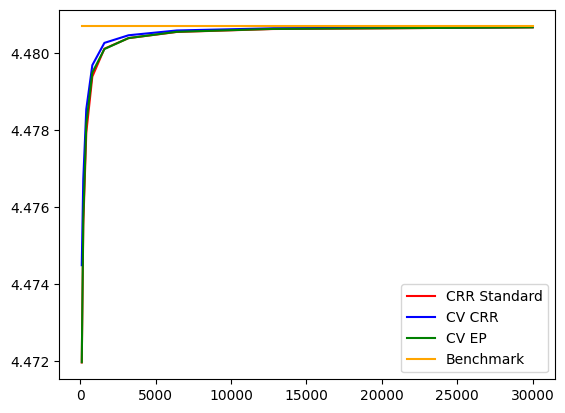

In [14]:
plt.plot(N, results_CRR, color = 'red', label = 'CRR Standard')
plt.plot(N, results_CV_CRR, color = 'blue', label = 'CV CRR')
plt.plot(N, results_CV_EP, color = 'green', label = 'CV EP')
plt.plot(N, Benchmark*np.ones(len(N)), color = 'orange', label = 'Benchmark')
plt.legend()
plt.show()

### Focus on how the strike price affects the performance of the algorithms in terms of the running time and accuracy.

In [15]:
S_0 = 40
K = [1, 4, 10, 20, 40, 50, 60, 80]
r = 0.1
sigma = 0.3
T = 3
N = 30000

results_CRR = []
time_CRR = []

results_CV_CRR = []
time_CV_CRR = []

results_CV_EP = []
time_CV_EP = []

for k in K:
    start_time = time.time()
    results_CRR.append(Binomial_price_Am(S_0, k, r, sigma, T, N))
    end_time = time.time()
    time_CRR.append(end_time - start_time)

    start_time = time.time()
    results_CV_CRR.append(CV_Enhanced_CRR(S_0, k, r, sigma, T, N))
    end_time = time.time()
    time_CV_CRR.append(end_time - start_time)

    start_time = time.time()
    results_CV_EP.append(CV_Enhaced_Equal_Probability(S_0, k, r, sigma, T, N))
    end_time = time.time()
    time_CV_EP.append(end_time - start_time)

In [16]:
# Calculate the Benchmark for different Strike Prices and compute the absolute errors
N = 50000
Benchmarks = []

for k in K:
    Benchmarks.append(Binomial_price_Am(S_0, k, r, sigma, T, N))

Abs_Error_CRR = np.abs(np.array(results_CRR) - np.array(Benchmarks))
Abs_Error_CV_CRR = np.abs(np.array(results_CV_CRR) - np.array(Benchmarks))
Abs_Error_CV_EP = np.abs(np.array(results_CV_EP) - np.array(Benchmarks))


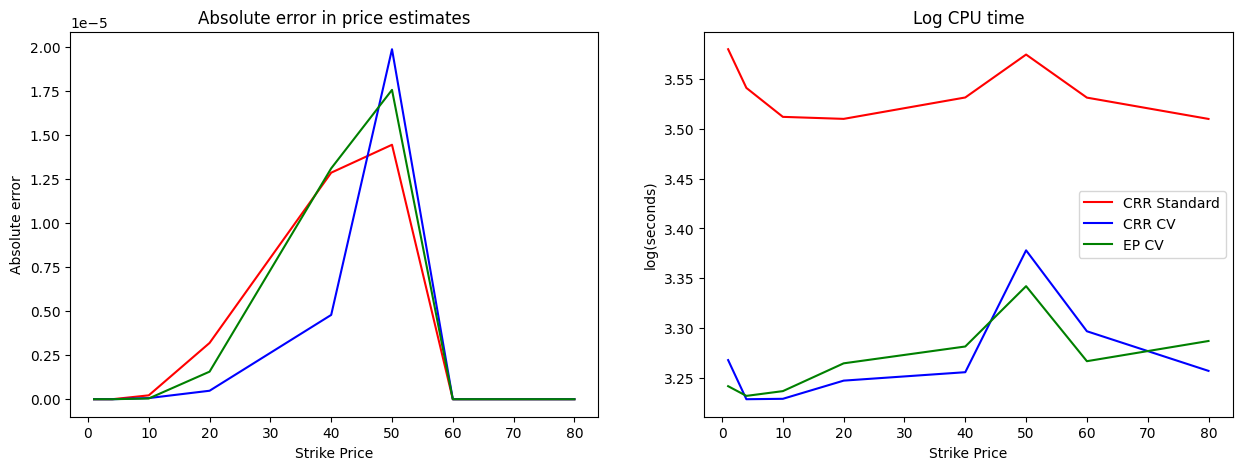

In [17]:
# Plotting the results
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (15,5))

ax1.plot(K, Abs_Error_CRR, color = 'red', label = 'CRR Standard')
ax1.plot(K, Abs_Error_CV_CRR, color = 'blue', label = 'CRR CV')
ax1.plot(K, Abs_Error_CV_EP, color = 'green', label = 'EP CV')
ax1.set_title("Absolute error in price estimates")
ax1.set_xlabel("Strike Price")
ax1.set_ylabel("Absolute error")

ax2.plot(K, np.log(time_CRR), color = 'red', label = 'CRR Standard')
ax2.plot(K, np.log(time_CV_CRR), color = 'blue', label = 'CRR CV')
ax2.plot(K, np.log(time_CV_EP), color = 'green', label = 'EP CV')
ax2.set_title("Log CPU time")
ax2.set_xlabel("Strike Price")
ax2.set_ylabel("log(seconds)")
plt.legend()
plt.show()

In [18]:
data = {
    "K": K,
    "CRR CPUs": time_CRR,
    "CRR Abs error": Abs_Error_CRR,
    "CV CRR CPU s": time_CV_CRR,
    "CV CRR Abs error": Abs_Error_CV_CRR,
    "CV EP CPU s": time_CV_EP,
    "CV EP Abs error": Abs_Error_CV_EP 
}

df = pd.DataFrame(data)
df

,K,CRR CPUs,CRR Abs error,CV CRR CPU s,CV CRR Abs error,CV EP CPU s,CV EP Abs error
0,1,35.869024,8.694898e-18,26.256937,1.154489e-17,25.578284,1.140526e-17
1,4,34.503335,1.437437e-10,25.245898,1.500449e-10,25.330465,1.429966e-10
2,10,33.515328,2.201751e-07,25.256443,6.440177e-08,25.451974,4.290037e-08
3,20,33.447650,3.192378e-06,25.721299,4.806077e-07,26.171696,1.563791e-06
4,40,34.173675,1.284753e-05,25.939765,4.780877e-06,26.617573,1.309225e-05
5,50,35.677768,1.443156e-05,29.313995,1.984946e-05,28.278647,1.754375e-05
6,60,34.168611,0.000000e+00,27.027674,0.000000e+00,26.227849,0.000000e+00
7,80,33.445581,0.000000e+00,25.974012,0.000000e+00,26.764968,0.000000e+00
